In [ ]:
###gpu code
#change the runtime type to gpu before execution
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Found GPU at: /device:GPU:0
Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
2.949334608999976
GPU (s):
0.0496355909999977
GPU speedup over CPU: 59x


In [ ]:
#packages
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import numpy as np
import os
from matplotlib import pyplot as plt
import cv2
import random
import pickle
import tensorflow as tf
from keras.models import load_model
from keras.preprocessing.image import load_img

Using TensorFlow backend.


In [ ]:
#use this lines of code if your data is in drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from glob import glob
 # useful for getting number of classes
folders = glob("/content/drive/My Drive/data/Images/*")
print(len(folders))
train_path = '/content/drive/My Drive/data/train'
valid_path = '/content/drive/My Drive/data/test'

21


In [ ]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# add a global spatial average pooling layer
x = base_model.output 
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)
# and a logistic layer -- let's say we have 21 classes
predictions = Dense(len(folders), activation='softmax')(x)



87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)
 
# Change the batchsize according to your system RAM
train_batchsize = 32
val_batchsize = 32

train_generator = train_datagen.flow_from_directory('/content/drive/My Drive/data/train',
        target_size=(299, 299),
        batch_size=train_batchsize,
        color_mode="rgb",
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory('/content/drive/My Drive/data/test',
        target_size=(299, 299),
        batch_size=val_batchsize,
        color_mode="rgb",
        class_mode='categorical',
        shuffle=False)

Found 1680 images belonging to 21 classes.
Found 420 images belonging to 21 classes.


In [ ]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# train the model on the new data for a few epochs
history = model.fit(
      train_generator,
      steps_per_epoch=len(train_generator) ,
      epochs=15,
      validation_data=validation_generator,
      validation_steps= len(validation_generator),
      verbose=1)


Epoch 1/15
53/53 [==============================] - 1144s 22s/step - loss: 2.2239 - accuracy: 0.4946 - val_loss: 1.1374 - val_accuracy: 0.6024
Epoch 2/15
53/53 [==============================] - 33s 629ms/step - loss: 0.7855 - accuracy: 0.7625 - val_loss: 0.5456 - val_accuracy: 0.8333
Epoch 3/15
53/53 [==============================] - 33s 631ms/step - loss: 0.5988 - accuracy: 0.8089 - val_loss: 0.5844 - val_accuracy: 0.8143
Epoch 4/15
53/53 [==============================] - 33s 628ms/step - loss: 0.4331 - accuracy: 0.8530 - val_loss: 0.4426 - val_accuracy: 0.8548
Epoch 5/15
53/53 [==============================] - 33s 630ms/step - loss: 0.3676 - accuracy: 0.8756 - val_loss: 0.3030 - val_accuracy: 0.9024
Epoch 6/15
53/53 [==============================] - 33s 630ms/step - loss: 0.3223 - accuracy: 0.8911 - val_loss: 0.4661 - val_accuracy: 0.8810
Epoch 7/15
53/53 [==============================] - 33s 632ms/step - loss: 0.2720 - accuracy: 0.9119 - val_loss: 0.4247 - val_accuracy: 0.8762

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d_22[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:279]:
   layer.trainable = False
for layer in model.layers[279:]:
   layer.trainable = True


0 input_1
1 conv2d_22
2 batch_normalization
3 activation
4 conv2d_23
5 batch_normalization_1
6 activation_1
7 conv2d_24
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_25
12 batch_normalization_3
13 activation_3
14 conv2d_26
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_30
19 batch_normalization_8
20 activation_8
21 conv2d_28
22 conv2d_31
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_27
29 conv2d_29
30 conv2d_32
31 conv2d_33
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_37
42 batch_normalization_15
43 activation_15
44 conv2d_35
45 conv2d_38
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_34
52 conv2d_36
53 conv2d_39
54 conv2d_40
55 batch_normalization_12
56 batch_normal

In [ ]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['acc'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=len(train_generator) ,
      epochs=25,
      validation_data=validation_generator,
      validation_steps= len(validation_generator),
      verbose=1)

# Save the model
model.save('incep_last4.h5')

Epoch 1/25
53/53 [==============================] - 36s 671ms/step - loss: 0.1972 - acc: 0.9369 - val_loss: 0.2378 - val_acc: 0.9262
Epoch 2/25
53/53 [==============================] - 34s 646ms/step - loss: 0.1210 - acc: 0.9589 - val_loss: 0.2079 - val_acc: 0.9357
Epoch 3/25
53/53 [==============================] - 34s 650ms/step - loss: 0.1034 - acc: 0.9708 - val_loss: 0.2039 - val_acc: 0.9333
Epoch 4/25
53/53 [==============================] - 34s 640ms/step - loss: 0.0989 - acc: 0.9690 - val_loss: 0.1987 - val_acc: 0.9381
Epoch 5/25
53/53 [==============================] - 34s 642ms/step - loss: 0.1042 - acc: 0.9673 - val_loss: 0.1966 - val_acc: 0.9405
Epoch 6/25
53/53 [==============================] - 34s 641ms/step - loss: 0.0794 - acc: 0.9780 - val_loss: 0.1937 - val_acc: 0.9405
Epoch 7/25
53/53 [==============================] - 34s 640ms/step - loss: 0.0731 - acc: 0.9798 - val_loss: 0.1901 - val_acc: 0.9405
Epoch 8/25
53/53 [==============================] - 34s 650ms/step - 

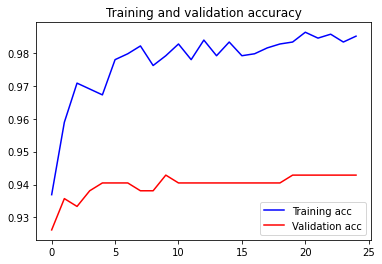

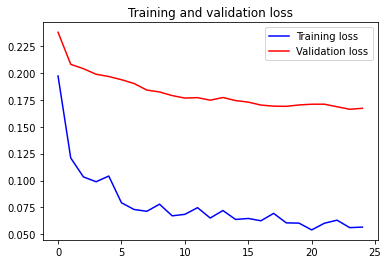

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
print("inception_v3:{}".format(max(acc)))

inception_v3:0.987500011920929


In [ ]:
#code to validate the complete testset
from keras.preprocessing import image
# Create a generator for prediction
validation_generator = validation_datagen.flow_from_directory('/content/drive/My Drive/data/test',
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

# Get the filenames from the generator
fnames = validation_generator.filenames
# Get the ground truth from generator
ground_truth = validation_generator.classes
# Get the label to class mapping from the generator
label2index = validation_generator.class_indices
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())
# Get the predictions from the model using the generator
predictions = model.predict(validation_generator, steps=len(validation_generator),verbose=1)
predicted_classes = np.argmax(predictions,axis=1)
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))
# Show the errors
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])
    original = load_img('{}/{}'.format('/content/drive/My Drive/data/test',fnames[errors[i]]))
    plt.figure(figsize=[2,2])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()